# Import the Required Libraries

In [4]:
#Imports
import torchvision.transforms.functional
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Prepare Custom Dataset and DataLoaders

In [7]:
# Prepare Custom Dataset Class
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "label": label
        }


# Transforms
train_pil_transform = v2.Compose([
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.8, 1.3),
                    interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.Resize(size=(256, 256)),
    v2.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

val_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_transforms = {
    "train": train_pil_transform,
    "val": val_pil_transform,
    "test": test_pil_transform,
}

# 🔁 Use your local path here
root_data_path = "./recyclable-and-household-waste-classification/images/images"

# Dataset setup
train_dataset = WasteDataset(root_data_path, "train", data_transforms["train"])
val_dataset = WasteDataset(root_data_path, "val", data_transforms["val"])
test_dataset = WasteDataset(root_data_path, "test", data_transforms["test"])

image_datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
}

class_names = train_dataset.classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
batch_size = 16

# Dataloaders
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=int(os.cpu_count() * 0.8))
val_data_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=int(os.cpu_count() * 0.2))
test_data_loader = DataLoader(test_dataset, batch_size, shuffle=True)

data_loaders = {
    "train": train_data_loader,
    "val": val_data_loader,
    "test": test_data_loader
}


# Visualize Images

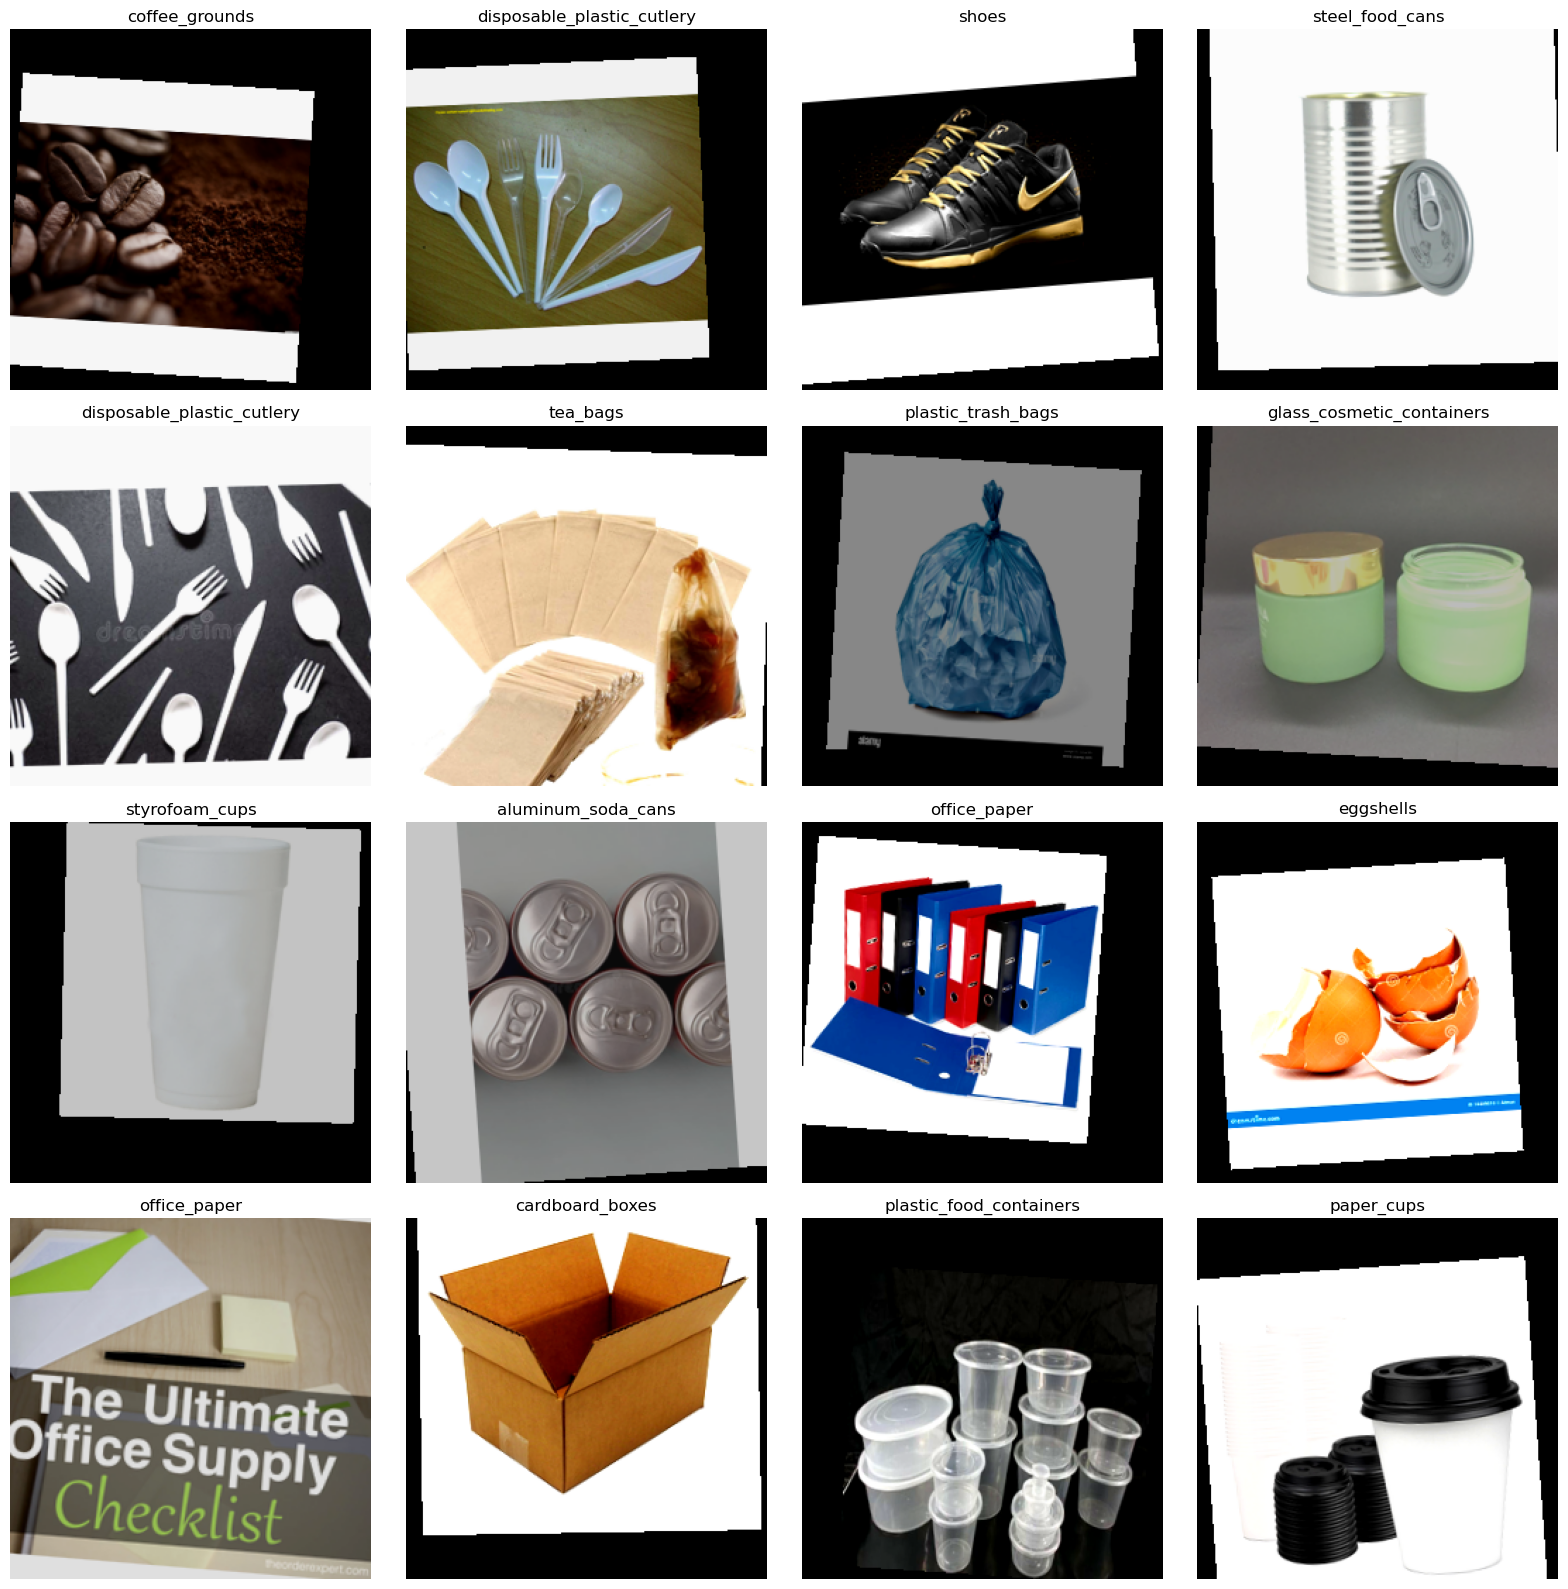

In [8]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(batch_size, batch_size))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    # loop over the batch size
    for i in range(0, batch_size):
        # create a subplot with 4x8
        ax = plt.subplot(4, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch["image"][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = std * image + mean
        image = image.astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch["label"][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

#visualize train data
train_batch = next(iter(data_loaders["train"]))
visualize_batch(train_batch,class_names,"train")

# Custom Waste Classification Model

In [9]:
class WasteClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobnet = mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        train_nodes, eval_nodes = get_graph_node_names(self.mobnet)
        self.feature_extraction = create_feature_extractor(self.mobnet,return_nodes={'features.12': 'mob_feature'})
        self.conv1 = nn.Conv2d(576,300,3)
        #self.conv2 = nn.Conv2d(300,150, 3)
        self.fc1 = nn.Linear(10800,30)
        #self.fc2 = nn.Linear(1000, 30)
        self.dr = nn.Dropout()

    def forward(self,x):
        feature_layer = self.feature_extraction(x)['mob_feature']
        x = F.relu(self.conv1(feature_layer))
        #x = F.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        x = self.dr(x)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        output = self.fc1(x)
        return output

# Model Training

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using Device {device}")

#Prepare Criterion and Optimizer
model = WasteClassificationModel()
model = model.to(device)
criterian = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

best_acc = {"train":-1000,
            "val":-1000}
best_loss = {"train":1000,
             "val":1000}

os.makedirs("checkpoints", exist_ok=True)

best_accuracy_model_path = {
    "train": os.path.join("checkpoints", "train_acc_best.pt"),
    "val": os.path.join("checkpoints", "val_acc_best.pt")
}
best_loss_model_path = {
    "train": os.path.join("checkpoints", "train_loss_best.pt"),
    "val": os.path.join("checkpoints", "val_loss_best.pt")
}

for epoch in range(num_epochs):

    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ["train", "val"]:
        if phase=="train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0

        for idx, data in enumerate(data_loaders[phase]):

            inputs, labels = data["image"].to(device), data["label"].to(device)

            model_optimizer.zero_grad()


            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterian(outputs, labels)


                if phase=="train":
                    loss.backward()
                    model_optimizer.step()

            ## statitics
            running_loss+=loss.item()*inputs.size(0)
            running_corrects+=torch.sum(preds==labels.data)

        # if phase=="train":
        #     scheduler.step()

        epoch_loss = running_loss/dataset_sizes[phase]
        epoch_acc = running_corrects/dataset_sizes[phase]

        print(f"{phase} Loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        #deep copy the model
        if epoch_acc>best_acc[phase]:
            best_acc[phase] = epoch_acc
            torch.save({
             'epoch':idx,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':model_optimizer.state_dict(),
                'loss':running_loss
            },best_accuracy_model_path[phase])

        if epoch_loss < best_loss[phase]:
            best_loss[phase] = epoch_loss
            torch.save({
                'epoch': idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': model_optimizer.state_dict(),
                'loss': running_loss
            }, best_loss_model_path[phase])





Using Device cuda:0
Epoch 0/49
----------
train Loss : 2.3623 Acc: 0.3492
val Loss : 1.8224 Acc: 0.4857
Epoch 1/49
----------
train Loss : 1.8664 Acc: 0.4751
val Loss : 1.5171 Acc: 0.5680
Epoch 2/49
----------
train Loss : 1.6656 Acc: 0.5321
val Loss : 1.1893 Acc: 0.6400
Epoch 3/49
----------
train Loss : 1.5173 Acc: 0.5727
val Loss : 1.4628 Acc: 0.6250
Epoch 4/49
----------
train Loss : 1.3996 Acc: 0.5944
val Loss : 1.2077 Acc: 0.6650
Epoch 5/49
----------
train Loss : 1.3758 Acc: 0.6123
val Loss : 1.0757 Acc: 0.6873
Epoch 6/49
----------
train Loss : 1.2771 Acc: 0.6318
val Loss : 1.2558 Acc: 0.6427
Epoch 7/49
----------
train Loss : 1.2545 Acc: 0.6409
val Loss : 0.9749 Acc: 0.7040
Epoch 8/49
----------
train Loss : 1.2129 Acc: 0.6557
val Loss : 0.9419 Acc: 0.7150
Epoch 9/49
----------
train Loss : 1.1749 Acc: 0.6614
val Loss : 0.9226 Acc: 0.7397
Epoch 10/49
----------
train Loss : 1.1328 Acc: 0.6723
val Loss : 0.9438 Acc: 0.7210
Epoch 11/49
----------
train Loss : 1.1362 Acc: 0.6799


# Accuracy of Validation Data

Loaded checkpoint from checkpoints/train_loss_best.pt

------- Classification Report -------

                            precision    recall  f1-score   support

              aerosol_cans       0.92      0.81      0.86       100
        aluminum_food_cans       0.61      0.44      0.51       100
        aluminum_soda_cans       0.79      0.72      0.75       100
           cardboard_boxes       0.61      0.60      0.60       100
       cardboard_packaging       0.60      0.60      0.60       100
                  clothing       0.89      0.79      0.84       100
            coffee_grounds       0.85      0.98      0.91       100
disposable_plastic_cutlery       0.88      0.92      0.90       100
                 eggshells       0.98      0.87      0.92       100
                food_waste       0.95      0.92      0.93       100
    glass_beverage_bottles       0.82      0.90      0.86       100
 glass_cosmetic_containers       0.87      0.82      0.85       100
           glass_food

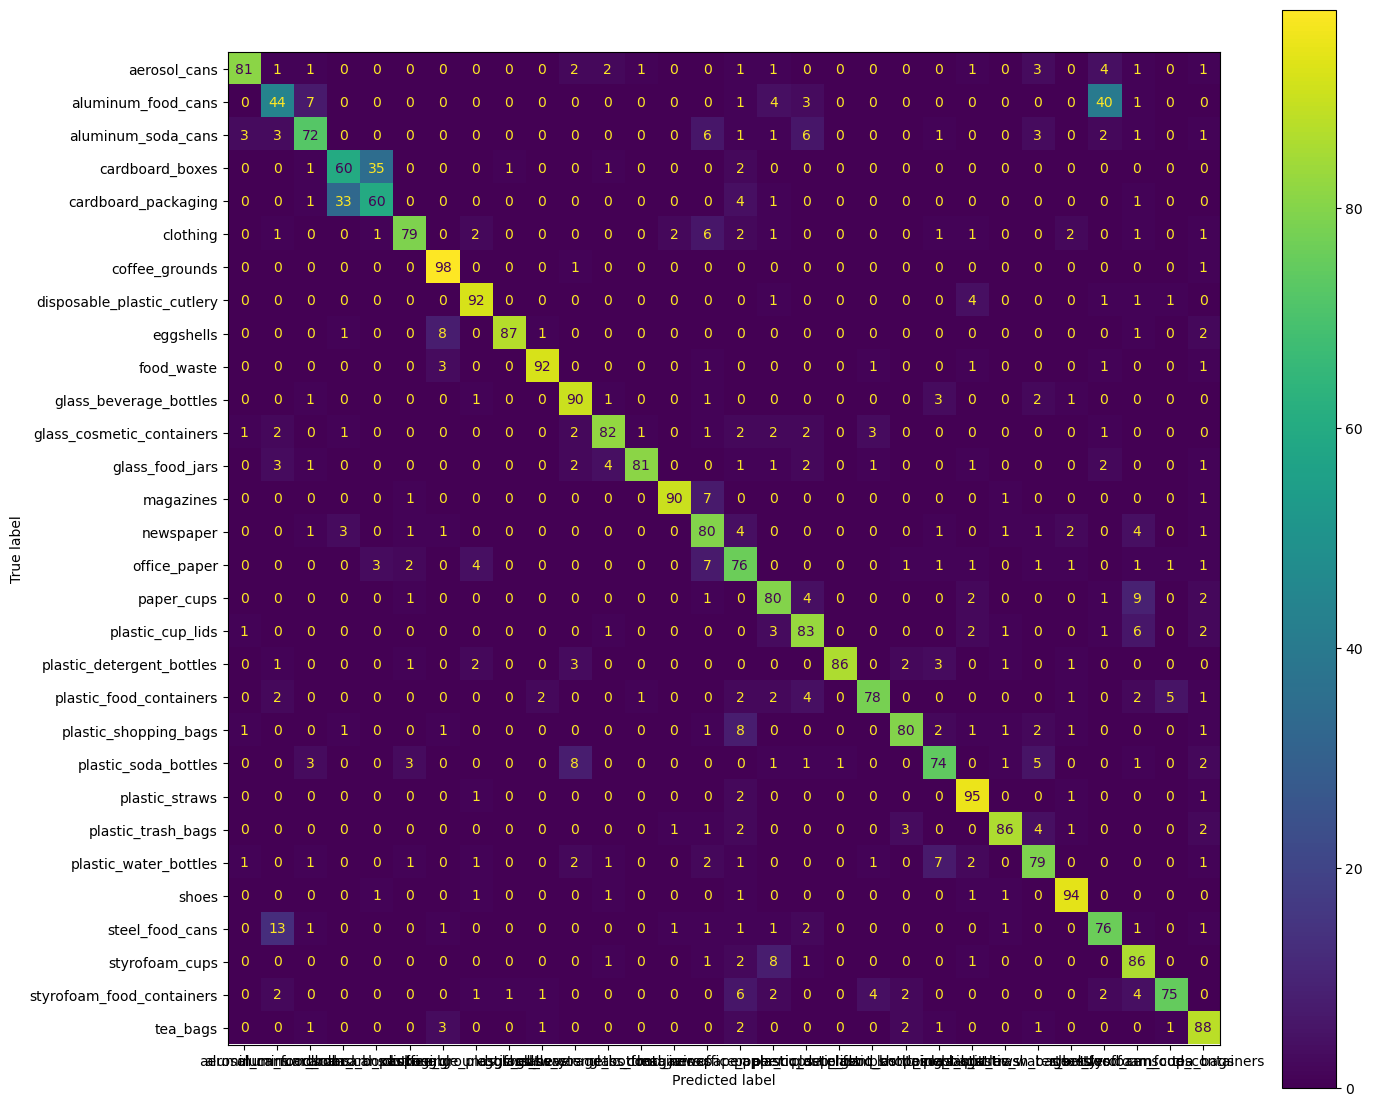

In [13]:
# === Load model checkpoint if available ===
checkpoint_path = "checkpoints/train_loss_best.pt"

model = WasteClassificationModel()
model.to(device)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    print(f"Checkpoint not found at {checkpoint_path}. Please train the model first.")
    # Optional: exit or raise an error if this is critical
    raise FileNotFoundError(f"{checkpoint_path} does not exist.")

# === Evaluate on validation set ===
data_size = len(image_datasets["val"])
y_preds = []
y_true = []

for idx, data in enumerate(data_loaders["val"]):
    inputs, labels = data["image"].to(device), data["label"].to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        y_preds.extend(predictions.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# === Print classification metrics ===
print("\n------- Classification Report -------\n")
print(classification_report(y_true, y_preds, target_names=class_names))

cm = confusion_matrix(y_true, y_preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(16, 14))
cm_disp.plot(ax=ax)
plt.show()


# Prediction on Sample Test Data

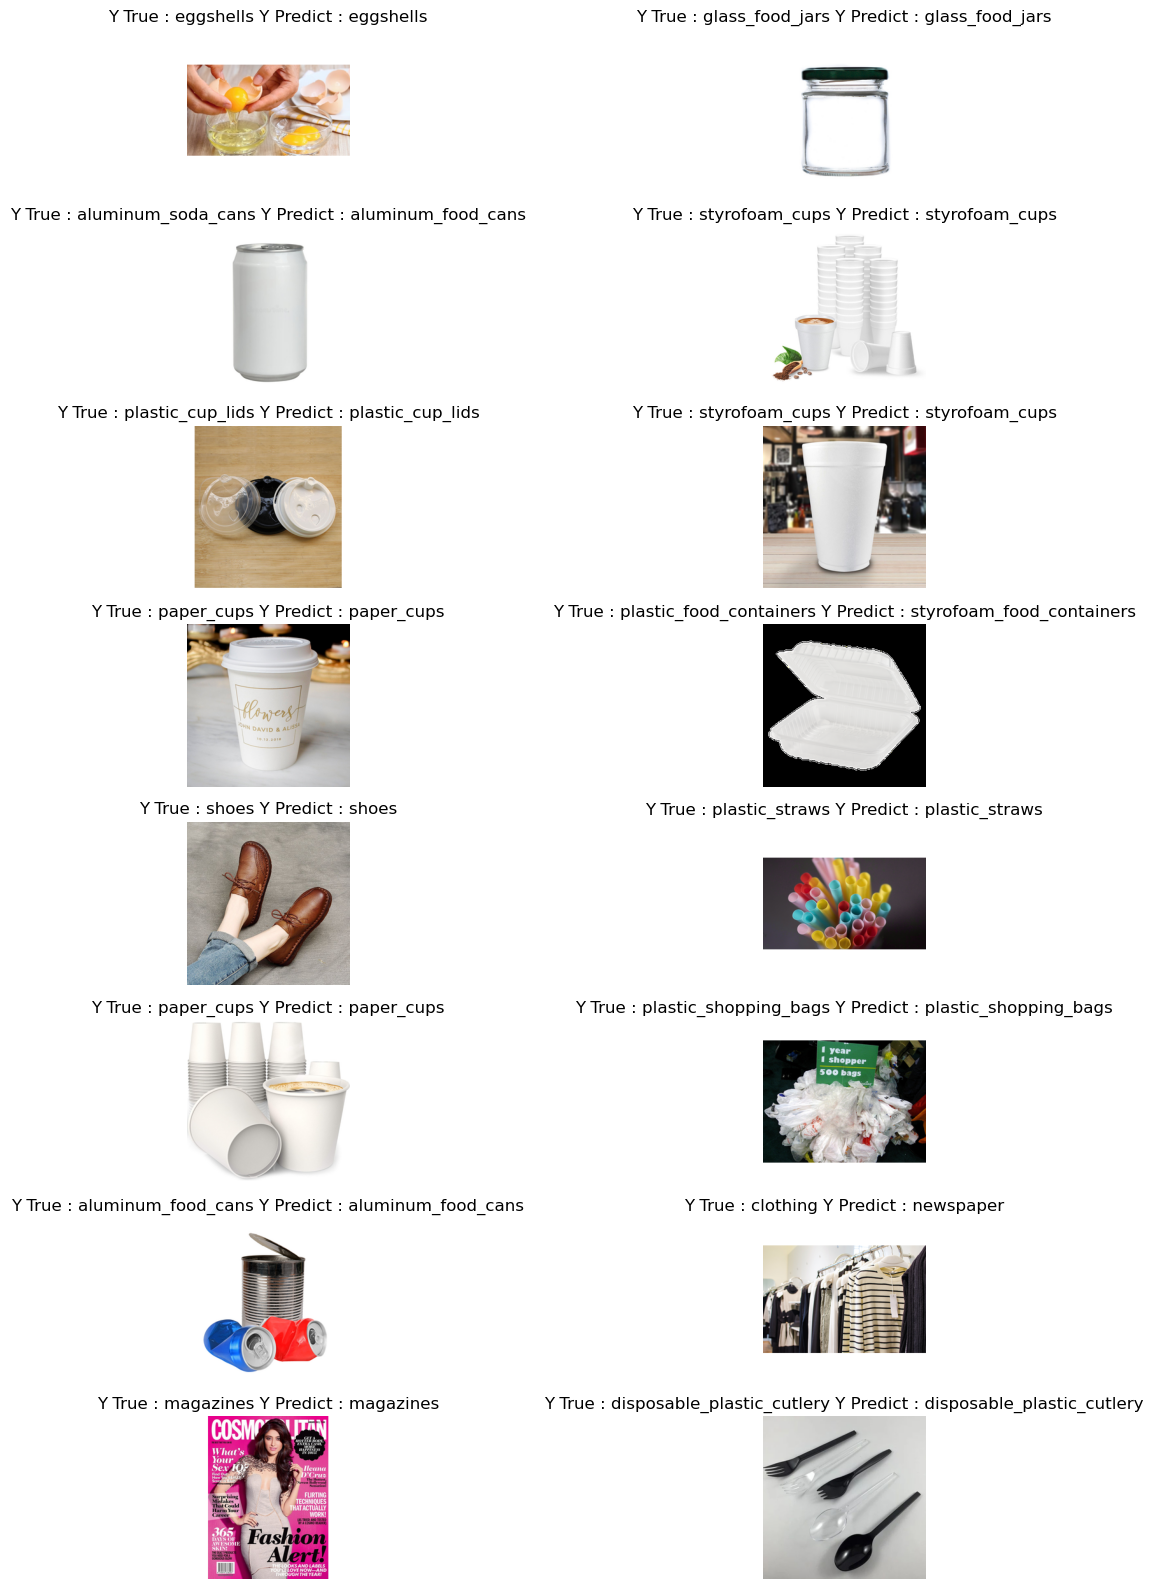

In [15]:
test_batch = next(iter(data_loaders["test"]))
inputs, labels = test_batch["image"].to(device), test_batch["label"].to(device)
outputs = model(inputs)
_, predictions = torch.max(outputs.data,1)


fig = plt.figure("Test Batch",
                     figsize=(batch_size, batch_size))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
# loop over the batch size
for i in range(len(predictions)):
    # create a subplot with 4x4
    ax = plt.subplot(8, 2, i + 1)
    # grab the image, convert it from channels first ordering to
    # channels last ordering, and scale the raw pixel intensities
    # to the range [0, 255]
    image = inputs[i].cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = std * image + mean
    image = image.astype("uint8")
    # grab the label id and get the label from the classes list
    idx = labels[i]
    true_label = class_names[idx]
    predicted_label = class_names[predictions[i]]
    # show the image along with the label
    plt.imshow(image)
    title_label = "Y True : {} Y Predict : {}".format(true_label,predicted_label)
    plt.title(title_label)
    plt.axis("off")
# show the plot
plt.tight_layout()
plt.show()

In [16]:
import torch

# Save model weights only
torch.save({
    'model_state_dict': model.state_dict()
}, 'mobilenet_transfer_learning_checkpoint.pth')